In [15]:
import os
import pandas as pd
from rouge import Rouge
import nltk
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("C:\\Users\\leshanbog\\Documents\\GitHub\\lasertagger\\model\\ria_test_pred.tsv", sep='\t', names=['text', 'pred', 'true'])
data = data.dropna()

In [3]:
data.shape

(4101, 3)

In [4]:
data.head()

,text,pred,true
0,"москв ##а , 25 апр - ри ##а новости . полны ##...",полны ##и состав жюри кан ##нского фестиваля о...,модельер ##а жан - поля гот ##ье позвал ##и в ...
1,18 апреля в волог ##де стартовал двухмесяч ##н...,в волог ##де стартовал двухмесяч ##ник по благ...,работники вологод ##ского кремля очист ##или м...
2,"каб ##ул , 21 апр - ри ##а новости , анд ##реи...",круп ##не ##иши ##и афган ##ски ##и банк ka ##...,часть активов рух ##нувшего ka ##bul bank буде...
3,"москв ##а , 31 ав ##г - ри ##а новости . возмо...",возможность сыграть повлияла на решение к ##еж...,форвард к ##еж ##ман перешел в ф ##к бат ##э и...
4,"москв ##а , 24 ноября - ри ##а новости . совет...",сов ##фе ##д одобрил закон о передаче имущества,сов ##фе ##д одобрил нашумев ##ши ##и закон о ...


In [5]:
refs = list(data['true'])
hyps = list(data['pred'])

In [6]:
def calc_legacy_rouge(refs, hyps, directory="eval"):
    from pyrouge import Rouge155
    r = Rouge155()
    system_dir = os.path.join(directory, 'hyp')
    model_dir = os.path.join(directory, 'ref')
    if not os.path.isdir(system_dir):
        os.makedirs(system_dir)
    if not os.path.isdir(model_dir):
        os.makedirs(model_dir)
    r.system_dir = system_dir
    r.model_dir = model_dir
    r.system_filename_pattern = '(\d+)_decoded.txt'
    r.model_filename_pattern = '#ID#_reference.txt'
    for i, (ref, hyp) in enumerate(zip(refs, hyps)):
        hyp_file_path = os.path.join(r.system_dir, "%06d_decoded.txt" % i)
        with open(hyp_file_path, "w") as w:
            hyp_sentences = hyp.split(" s_s ")
            w.write("\n".join(hyp_sentences))
        ref_file_path = os.path.join(r.model_dir, "%06d_reference.txt" % i)
        with open(ref_file_path, "w") as w:
            ref_sentences = ref.split(" s_s ")
            w.write("\n".join(ref_sentences))
    output = r.convert_and_evaluate()
    result = r.output_to_dict(output)
    log_str = ""
    for x in ["1","2","l"]:
        log_str += "\nROUGE-%s:\n" % x
        for y in ["f_score", "recall", "precision"]:
            key = "rouge_%s_%s" % (x,y)
            key_cb = key + "_cb"
            key_ce = key + "_ce"
            val = result[key]
            val_cb = result[key_cb]
            val_ce = result[key_ce]
            log_str += "%s: %.4f with confidence interval (%.4f, %.4f)\n" % (key, val, val_cb, val_ce)
    return log_str


def calc_metrics(refs, hyps):
    print("Count:", len(hyps))
    print("Ref:", refs[-2])
    print("Hyp:", hyps[-2])

    from nltk.translate.bleu_score import corpus_bleu
    print("BLEU: ", corpus_bleu([[r] if r is not list else r for r in refs], hyps))
    rouge = Rouge()
    scores = rouge.get_scores(hyps, refs, avg=True)
    print("ROUGE: ", scores)

In [7]:
calc_metrics(refs, hyps)

Count: 4101
Ref: якут ##ия и тур ##ция готовы развивать сотрудничество
Hyp: якут ##ия и тур ##ция договорились активизировать сотрудничество
BLEU:  0.5494807540345582
ROUGE:  {'rouge-1': {'f': 0.4650869262093979, 'p': 0.49596495861522455, 'r': 0.45144142430156126}, 'rouge-2': {'f': 0.31660838857106344, 'p': 0.3393940729259551, 'r': 0.30743130255474055}, 'rouge-l': {'f': 0.4246788167667025, 'p': 0.46645691754274143, 'r': 0.4237033569378699}}


In [8]:
n = random.randint(0, len(refs) - 1)

In [9]:
data['text'][n].replace(' ##', '')

'москва , 2 окт - риа новости . россиянка анастасия павлюченкова переиграла чешку барбору заглавову - стрыкову в первом круге теннисного турнира в пекине , призовои фонд которого составляет 4 , 5 миллиона долларов . встреча , состоявшаяся в воскресенье , завершилась со счетом 7 : 5 , 6 : 4'

In [10]:
data['pred'][n].replace(' ##', '')

'павлюченкова вышла в первом круге теннисного турнира в пекине'

In [11]:
data['true'][n].replace(' ##', '')

'павлюченкова пробилась во второи круг теннисного турнира в пекине'

In [12]:
from_first_sentence_tokens_percert = []

for i in range(len(data['text'])):
    sent_tokens = data['text'].iloc[i].split()
    try:
        header_end_pos = sent_tokens.index('.')
    except:
        continue
        
    try:
        first_sent = sent_tokens[header_end_pos + 1 : header_end_pos + sent_tokens[header_end_pos + 1:].index('.')]
    except:
        first_sent = sent_tokens[header_end_pos + 1 : -1]

    pred_tokens = data['pred'].iloc[i].split()
    token_from_first_sent_cnt = 0
    for el in pred_tokens:
        if el in first_sent:
            token_from_first_sent_cnt += 1
    
    from_first_sentence_tokens_percert.append(token_from_first_sent_cnt / len(pred_tokens))
    

In [13]:
sum(from_first_sentence_tokens_percert) / len(from_first_sentence_tokens_percert)

0.823046408239825

In [14]:
sorted(from_first_sentence_tokens_percert)[len(from_first_sentence_tokens_percert)//2]

0.9375

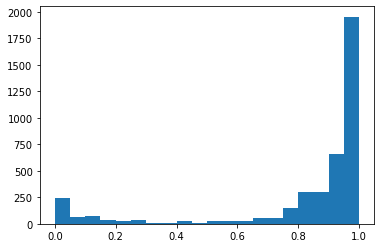

In [19]:
plt.hist(from_first_sentence_tokens_percert, 20)
plt.show()